# 1. Setup

## 1a. Install required packages

In [ ]:
!pip install geopandas
!pip install Shapely

In [2]:
# Silence warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# CSV management
import pandas as pd

# Downloads and path management
import requests
import pathlib
import os

# Geographic analysis
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry import MultiLineString
from shapely.ops import split

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, PercentFormatter)

# Dates
from datetime import datetime

# Numerical
import numpy as np

# Analysis
import scipy

## 1b. Set filepaths

In [3]:
path = pathlib.Path().resolve()
INPUT_FILEPATH = path / "data"
OUTPUT_FILEPATH = path / "data" / "outputs"

## 1c. Load required data

In [4]:
# Geographic data
ct_boundaries = gpd.read_file(OUTPUT_FILEPATH / "ct_boundaries.gpkg")
ct_subcounties = gpd.read_file(OUTPUT_FILEPATH / "ct_subcounties.gpkg")
ct_zips = gpd.read_file(OUTPUT_FILEPATH / "ct_zips.gpkg")

# Routes
state_routes= gpd.read_file(OUTPUT_FILEPATH / "state_routes.gpkg" )
local_roads = gpd.read_file(OUTPUT_FILEPATH / "local_roads.gpkg" )
interstates = gpd.read_file(OUTPUT_FILEPATH / "interstates.gpkg")
ramps       = gpd.read_file(OUTPUT_FILEPATH / "ramps.gpkg")
                              
# Charging points
charging_points = gpd.read_file(OUTPUT_FILEPATH / "afdc_ct_charging_points.gpkg")  

# Income data (with subcounty geographies)
subcounties_income = gpd.read_file(OUTPUT_FILEPATH / "ct_subcounties_income_merged.gpkg")
zips_income = pd.read_csv(INPUT_FILEPATH / "S1901_CT_income_by_zip.csv", header = 0)[1:]

In [5]:
# EV Purchase data
vehicle_reg_by_year = pd.read_csv(OUTPUT_FILEPATH /"vehicle_sales_by_year.csv" )

In [6]:
# EV Purchase data by zip, with geographic data
ev_purchases_by_zip_geo = gpd.read_file(OUTPUT_FILEPATH / "ev_sales_by_zip_geo.gpkg")

# 2. Outputs

## 2a. CT Road Network & Charging Points

Text(0.5, 0.01, 'Source: NREL Alternative Fuels Data Center Database')

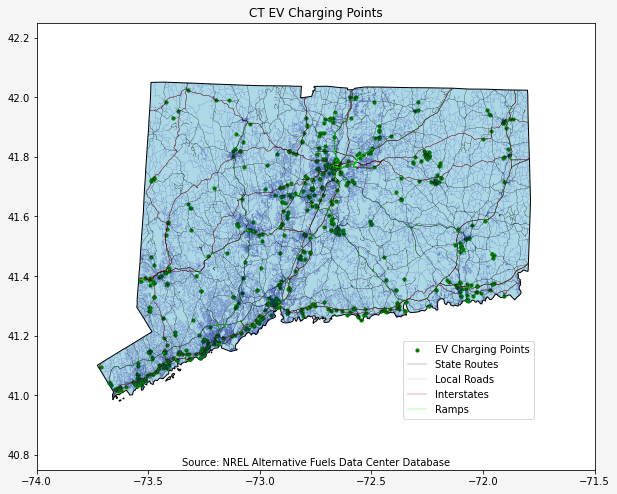

In [5]:
# Create figure and axes
fig, ax = plt.subplots(figsize = (10,10), facecolor = 'whitesmoke')

# Set axes sizes
ax.set_ylim(40.75, 42.25)
ax.set_xlim(-74, -71.5)

# Plot state and points
# Plot state boundaries
ct_boundaries.plot(ax=ax, color = 'lightblue', edgecolor = 'black')

# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, 
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

# Plot state routes
state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

# Plot local roads
local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

# Plot interstates and US routes
interstates_plot = interstates.plot(ax=ax, color ='darkred', linewidth = 0.3, label = "Interstates")

# Plot ramps
ramps_plot = ramps.plot(ax=ax, color='lime', linewidth = 0.3, label = "Ramps")

# We get our handles and labels
handles, labels = ax.get_legend_handles_labels()

# Choose to place this within the figure, not within the axes
ax.legend(handles, labels, loc = 'upper right', bbox_to_anchor = (0.9, 0.3))

ax.set_title("CT EV Charging Points")
plt.text(s = "Source: NREL Alternative Fuels Data Center Database",
         x = 0.5,
         y= 0.01,
         transform=ax.transAxes,
         horizontalalignment='center')

## 2b. Charging Network & Median Income

### 2bi. Number of chargers by income (county) - Map

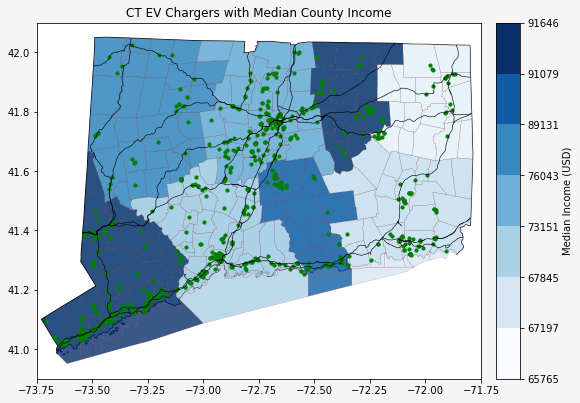

In [28]:
# Map
# Plot these
# Create figure and axes
fig, ax = plt.subplots(figsize = (10,10), facecolor = 'whitesmoke')


# Split them
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "4%", pad = "-10%")

# Set axes sizes
ax.set_title("CT EV Chargers with Median County Income")
ax.set_ylim(40.9, 42.1)
ax.set_xlim(-73.75, -71.75)

# Create a colormap
cmap = plt.cm.Blues
norm = colors.BoundaryNorm(sorted(subcounties_income["Median"].unique()), cmap.N)

# Plot state and points
# Plot state boundaries
ct_boundaries.plot(ax=ax,
              cax=cax,
              color = 'lightblue',
              edgecolor = 'black')

# Plot the counties
# Legend_kwds are passed to a matplotlib.pyplot.colorbar() object, so they must match those
# Found here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
subcounties_income.plot(ax=ax,
                        column = "Median",
                        cax=cax,
                        cmap = cmap, norm=norm, legend = True,
                        legend_kwds={"label": "Median Income (USD)",
                                    "pad" : 0},
                        alpha = 0.8)
# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, cax=cax,
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

# Plot county subdivisions
counties_sub_plot = ct_subcounties.plot(ax=ax, cax=cax,
                    edgecolor = 'darkred',
                    facecolor = 'none',
                    linewidth = 0.1)


# Plot state routes
# state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

# Plot local roads
# local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

# Plot interstates and US routes
interstates_plot = interstates.plot(ax=ax, cax=cax, color ='black', linewidth = 0.6, label = "Interstates")

plt.show()



### 2bi. Number of chargers by income (county) - Plot

In [109]:
# Create a blank column
charging_points["GEOID"] = 0

# Loop through all charging points
for i in range(len(charging_points)):
    # Loop through all subcounties
    for j in range(len(subcounties_income)):
        if charging_points["geometry"][i].within(subcounties_income["geometry"][j]):
            charging_points.iloc[i, charging_points.columns.isin(["GEOID"])] = subcounties_income["GEOID"][j]
            
# Number of chargers by GEOID
charging_points_by_geoid = charging_points.groupby("GEOID").sum()[["EV Level1 EVSE Num", "EV Level2 EVSE Num", "EV DC Fast Count"]].reset_index()

# Get add median income
charging_points_by_geoid_income = charging_points_by_geoid.merge(subcounties_income[["GEOID","Median"]], 
                                                                                    left_on = "GEOID",
                                                                                   right_on = "GEOID")

# Prepare the data to be plotted
charging_points_by_geoid_income = charging_points_by_geoid_income.sort_values("Median")
charging_points_by_geoid_income["Median"] = charging_points_by_geoid_income["Median"].astype(str)
charging_points_by_geoid_income = charging_points_by_geoid_income.groupby("Median").sum().reset_index()

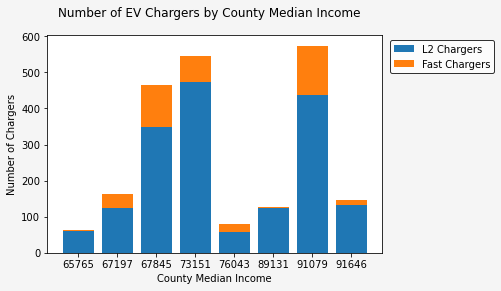

In [197]:
# Create figure
fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'whitesmoke')

# Add L2
l2 = ax.bar(x = "Median",
       height = "EV Level2 EVSE Num",
       align = 'center',
       data = charging_points_by_geoid_income,
       width = 0.8,
       label = "L2 Chargers")

# Add L3
l3 = ax.bar(x = "Median",
       height = "EV DC Fast Count",
       align = 'center',
       data =charging_points_by_geoid_income ,
       bottom = "EV Level2 EVSE Num",
       width = 0.8,
       label = "Fast Chargers")

# Set labels and legend
ax.set_xlabel("County Median Income")
ax.set_ylabel("Number of Chargers")
plt.legend(bbox_to_anchor = (1.35,1), 
           edgecolor = 'black')

# Add title
plt.suptitle("Number of EV Chargers by County Median Income")
plt.show()

### 2bii. Number of chargers by income (zip)

In [ ]:
# Prepare data
zips_income_merge = zips_income.copy(deep = True)
zips_income_merge["ZIP"]=zips_income_merge["ZIP"].astype(str).str[:-2]
zips_income_merge = zips_income_merge[["S1901_C01_012E", "ZIP"]]
zips_income_merge["ZIP"] = zips_income_merge["ZIP"].astype(int)

In [65]:
# Merge zip income data with geographic data
ct_zips_geo_income = ct_zips.copy(deep=True)
ct_zips_geo_income["ZIP"] = ct_zips_geo_income["ZCTA5CE20"].astype(str).str[1:].astype(int)
ct_zips_geo_income = ct_zips_geo_income.merge(zips_income_merge,
                                             how = 'left',
                                             left_on = "ZIP",
                                             right_on = "ZIP")

# Clean up
ct_zips_geo_income["S1901_C01_012E"] = ct_zips_geo_income["S1901_C01_012E"].replace('-','0')
ct_zips_geo_income["S1901_C01_012E"] = ct_zips_geo_income["S1901_C01_012E"].astype('Int64')
ct_zips_geo_income["S1901_C01_012E"] = ct_zips_geo_income["S1901_C01_012E"].fillna(0)
ct_zips_geo_income["S1901_C01_012E"] = ct_zips_geo_income["S1901_C01_012E"].astype(float)

# Create a percentile column
ct_zips_geo_income["S1901_C01_012E_pct"] = ct_zips_geo_income["S1901_C01_012E"].rank(pct=True)

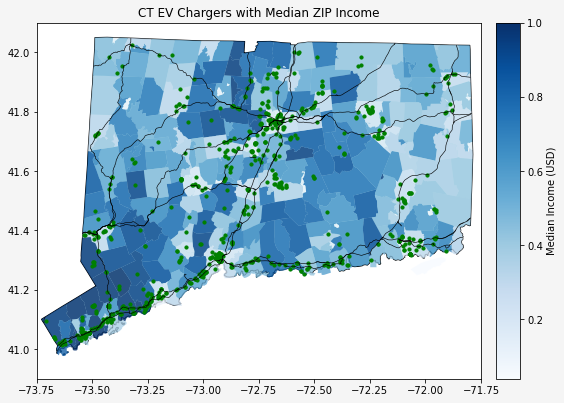

In [66]:
# Map
# Plot these
# Create figure and axes
fig, ax = plt.subplots(figsize = (10,10), facecolor = 'whitesmoke')


# Split them
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "4%", pad = "-10%")

# Set axes sizes
ax.set_title("CT EV Chargers with Median ZIP Income")
ax.set_ylim(40.9, 42.1)
ax.set_xlim(-73.75, -71.75)

# Create a colormap
# cmap = plt.cm.Blues
# norm = colors.BoundaryNorm(sorted(ct_zips_geo_income["S1901_C01_012E"].unique()), cmap.N)

# Plot state and points
# Plot state boundaries
ct_boundaries.plot(ax=ax,
              cax=cax,
              color = 'lightblue',
              edgecolor = 'black')

# Plot the counties
# Legend_kwds are passed to a matplotlib.pyplot.colorbar() object, so they must match those
# Found here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
ct_zips_geo_income.plot(ax=ax,
                        column = "S1901_C01_012E_pct",
                        cax=cax,
                        cmap = 'Blues', legend = True,
                        legend_kwds={"label": "Median Income (USD)",
                                    "pad" : 0},
                        alpha = 0.8)
# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, cax=cax,
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

interstates_plot = interstates.plot(ax=ax, cax=cax, color ='black', linewidth = 0.6, label = "Interstates")

plt.show()


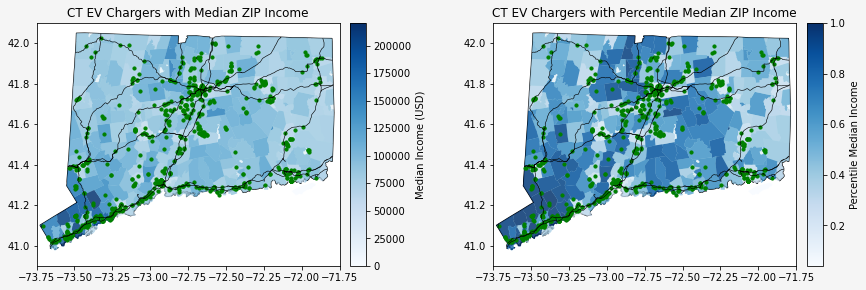

In [85]:
# Map
# Plot these
# Create figure and axes
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5), facecolor = 'whitesmoke')
ax = axs[1]
ax1= axs[0]

# Change spacing
fig.subplots_adjust(wspace=0.2)

# Split them
divider = make_axes_locatable(ax)
divider_2 = make_axes_locatable(ax1)
cax = divider.append_axes("right", size = "4%", pad = "-10%")
cax_2 = divider_2.append_axes("right", size = "4%", pad = "-10%")

# --- Create left plot --- 
# Set axes sizes
ax.set_title("CT EV Chargers with Percentile Median ZIP Income")
ax.set_ylim(40.9, 42.1)
ax.set_xlim(-73.75, -71.75)

# Create a colormap
# cmap = plt.cm.Blues
# norm = colors.BoundaryNorm(sorted(ct_zips_geo_income["S1901_C01_012E"].unique()), cmap.N)

# Plot state and points
# Plot state boundaries
ct_boundaries.plot(ax=ax,
              cax=cax,
              color = 'lightblue',
              edgecolor = 'black')

# Plot the counties
# Legend_kwds are passed to a matplotlib.pyplot.colorbar() object, so they must match those
# Found here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
ct_zips_geo_income.plot(ax=ax,
                        column = "S1901_C01_012E_pct",
                        cax=cax,
                        cmap = 'Blues', legend = True,
                        legend_kwds={"label": "Percentile Median Income",
                                    "pad" : 0},
                        alpha = 0.8)
# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, cax=cax,
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

interstates_plot = interstates.plot(ax=ax, cax=cax, color ='black', linewidth = 0.6, label = "Interstates")


# --- Create right plot --- 
# Set axes sizes
ax1.set_title("CT EV Chargers with Median ZIP Income")
ax1.set_ylim(40.9, 42.1)
ax1.set_xlim(-73.75, -71.75)

# Create a colormap
# cmap = plt.cm.Blues
# norm = colors.BoundaryNorm(sorted(ct_zips_geo_income["S1901_C01_012E"].unique()), cmap.N)

# Plot state and points
# Plot state boundaries
ct_boundaries.plot(ax=ax1,
              cax=cax_2,
              color = 'lightblue',
              edgecolor = 'black')

# Plot the counties
# Legend_kwds are passed to a matplotlib.pyplot.colorbar() object, so they must match those
# Found here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
ct_zips_geo_income.plot(ax=ax1,
                        column = "S1901_C01_012E",
                        cax=cax_2,
                        cmap = 'Blues', legend = True,
                        legend_kwds={"label": "Median Income (USD)",
                                    "pad" : 0},
                        alpha = 0.8)
# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax1, cax=cax_2,
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

interstates_plot = interstates.plot(ax=ax1, cax=cax_2, color ='black', linewidth = 0.6, label = "Interstates")

plt.savefig(OUTPUT_FILEPATH/'0925_Chargers_Income.png', dpi=300)

### 2bii. Number of chargers by income (zip) - Plot

In [8]:
# Prepare charging point data to merge
charging_points_zip_merge = charging_points.copy(deep=True)
charging_points_zip_merge = charging_points_zip_merge[["ZIP", 'EV Level1 EVSE Num',
       'EV Level2 EVSE Num', 'EV DC Fast Count']]
charging_points_zip_merge = charging_points_zip_merge.fillna(0)
charging_points_zip_merge = charging_points_zip_merge.groupby("ZIP").sum().reset_index()

# Complete merge
charging_points_zip_merge = charging_points_zip_merge.merge(zips_income_merge, left_on = "ZIP", right_on = "ZIP")
charging_points_zip_merge = charging_points_zip_merge.sort_values("S1901_C01_012E")
charging_points_zip_merge["S1901_C01_012E"] = charging_points_zip_merge["S1901_C01_012E"].replace('-',0)
charging_points_zip_merge["S1901_C01_012E"] = charging_points_zip_merge["S1901_C01_012E"].astype(float)

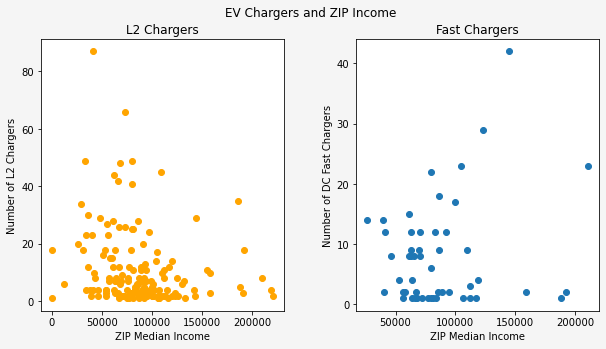

In [105]:
# Create joint figure
fig, axs = plt.subplots(nrows = 1, ncols = 2,
                        figsize = (10,5),
                        facecolor = 'whitesmoke')

# Adjust spacing
fig.subplots_adjust(wspace = 0.3)

# Split axes
ax = axs[0]
ax1 = axs[1]

# Create first subplot
l2 = ax.scatter(x= "S1901_C01_012E",
       y="EV Level2 EVSE Num",
       data = charging_points_zip_merge[charging_points_zip_merge["EV Level2 EVSE Num"]!=0],
       label = "L2 Chargers", color = 'orange')
ax.set_ylabel("Number of L2 Chargers")
ax.set_xlabel("ZIP Median Income")
ax.set_title("L2 Chargers")

# Create second subplot
l2 = ax1.scatter(x= "S1901_C01_012E",
       y="EV DC Fast Count",
       data = charging_points_zip_merge[charging_points_zip_merge["EV DC Fast Count"]!=0],
       label = "Fast Chargers")
ax1.set_ylabel("Number of DC Fast Chargers")
ax1.set_xlabel("ZIP Median Income")
ax1.set_title("Fast Chargers")


# Create title
fig.suptitle("EV Chargers and ZIP Income", y = 0.97)

# Save figure
plt.savefig(OUTPUT_FILEPATH/'0925_Chargers_Income_Plot.png', dpi=500)

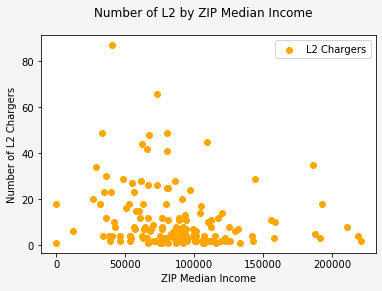

In [9]:
# Create figure
fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'whitesmoke')

l2 = ax.scatter(x= "S1901_C01_012E",
       y="EV Level2 EVSE Num",
       data = charging_points_zip_merge[charging_points_zip_merge["EV Level2 EVSE Num"]!=0],
       label = "L2 Chargers", color = 'orange')
ax.set_ylabel("Number of L2 Chargers")
ax.set_xlabel("ZIP Median Income")

plt.suptitle("Number of L2 by ZIP Median Income")
plt.legend()

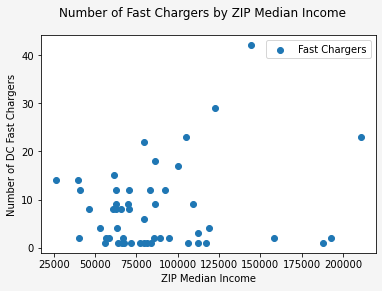

In [86]:
# Create figure
fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'whitesmoke')

l2 = ax.scatter(x= "S1901_C01_012E",
       y="EV DC Fast Count",
       data = charging_points_zip_merge[charging_points_zip_merge["EV DC Fast Count"]!=0],
       label = "Fast Chargers")
ax.set_ylabel("Number of DC Fast Chargers")
ax.set_xlabel("ZIP Median Income")

plt.suptitle("Number of Fast Chargers by ZIP Median Income")
plt.legend()

## 2c. Fuel type over time

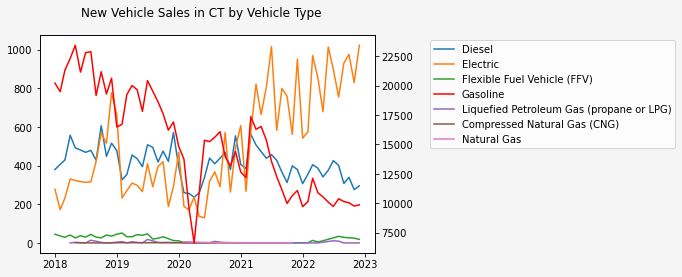

In [106]:
lns = None

# Make datetime
vehicle_reg_by_year['Date']= pd.to_datetime(vehicle_reg_by_year['Date'])

# Plot this
fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'whitesmoke')

# Do with categories
for fueltype in vehicle_reg_by_year["FuelTypePrimary"].unique():
    i = 0
    if fueltype != "Gasoline":
        ln = ax.plot(vehicle_reg_by_year[vehicle_reg_by_year["FuelTypePrimary"] == fueltype]["Date"],
               vehicle_reg_by_year[vehicle_reg_by_year["FuelTypePrimary"] == fueltype]["VEH_COUNT"],
               label = fueltype)
        
        # Add legends together
        try:
            lns = lns + ln
        except:
            lns = ln
    else:
        ax2 = ax.twinx()
        ln2 = ax2.plot(vehicle_reg_by_year[vehicle_reg_by_year["FuelTypePrimary"] == fueltype]["Date"],
               vehicle_reg_by_year[vehicle_reg_by_year["FuelTypePrimary"] == fueltype]["VEH_COUNT"],
               label = fueltype,
               color = 'red')
        lns += ln2


labs = [l.get_label() for l in lns]

# Get rid of some pesky nas
labs = labs[0:4]+labs[5:]
lns = lns[0:4]+lns[5:]

# Create legend
ax.legend(lns, labs, bbox_to_anchor = (1.15, 1))

#ax.legend(bbox_to_anchor = (1.2, 1))
# ax2.legend(bbox_to_anchor = (0.7, 0.2))

fig.suptitle("New Vehicle Sales in CT by Vehicle Type")
plt.savefig(OUTPUT_FILEPATH/ "0925_NV_sales_by_type.png", dpi=500)

## 2d. EV Sales as percentage of total by ZIP

### Plotting

C:\Users\rajan\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


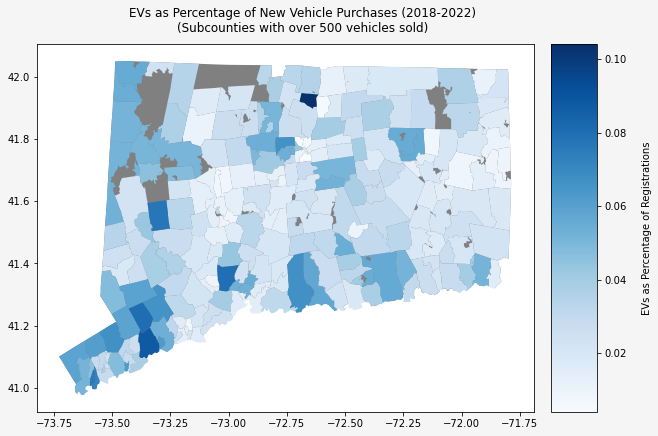

In [211]:
# Restrict to geographies with vehicle sales above 100
ev_purchases_by_zip_geo_filtered = ev_purchases_by_zip_geo[ev_purchases_by_zip_geo["TOTAL_VEH_COUNT"]>500]

# Clean up
ev_purchases_by_zip_geo_filtered["Percentage"] = ev_purchases_by_zip_geo_filtered["Percentage"] /100

# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,10), facecolor = 'whitesmoke')

# Create divider
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "7%", pad = "-10%")
cax.yaxis.labelpad = 15

# Add plots
ct_bg = ct_boundaries.plot(ax=ax, 
                           facecolor = 'grey')

# Add zips and sales
ev_purchases_by_zip_geo_filtered.plot(ax=ax,
                    column = "Percentage",
                    cmap = 'Blues',
                    cax = cax,
                    legend = True,
                    legend_kwds={"label": "EVs as Percentage of Registrations",
                                  "pad" : 0,
                                 'format':"%.2f"})

# Add title
fig.suptitle("EVs as Percentage of New Vehicle Purchases (2018-2022)\n(Subcounties with over 500 vehicles sold)", y = 0.78)

# plt.legend()

plt.tight_layout()
plt.show()

C:\Users\rajan\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\rajan\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


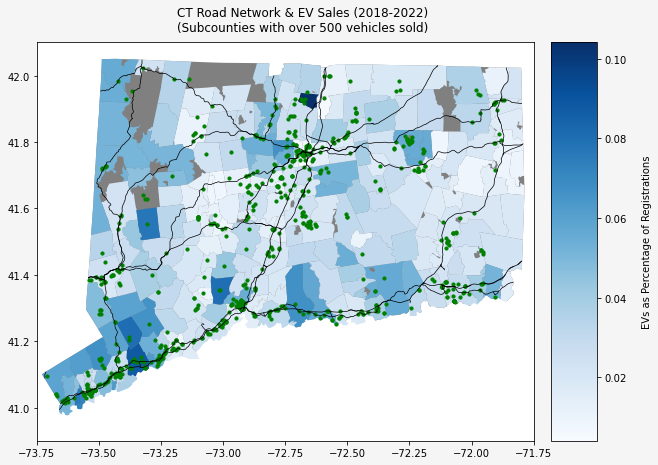

In [55]:
# Restrict to geographies with vehicle sales above 100
ev_purchases_by_zip_geo_filtered = ev_purchases_by_zip_geo[ev_purchases_by_zip_geo["TOTAL_VEH_COUNT"]>500]

# Clean up
ev_purchases_by_zip_geo_filtered["Percentage"] = ev_purchases_by_zip_geo_filtered["Percentage"] /100
# Create percentile
ev_purchases_by_zip_geo_filtered["Percentage_Percentile"] = ev_purchases_by_zip_geo_filtered["Percentage"].rank(pct=True)

# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,10), facecolor = 'whitesmoke')
ax.set_ylim(40.9, 42.1)
ax.set_xlim(-73.75, -71.75)

# Create divider
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "7%", pad = "-10%")
cax.yaxis.labelpad = 15

# Add plots
ct_bg = ct_boundaries.plot(ax=ax, 
                           facecolor = 'grey')

# Add zips and sales
ev_purchases_by_zip_geo_filtered.plot(ax=ax,
                    column = "Percentage",
                    cmap = 'Blues',
                    cax = cax,
                    legend = True,
                    legend_kwds={"label": "EVs as Percentage of Registrations",
                                  "pad" : 0,
                                 'format':"%.2f"})

# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, 
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

# Plot state routes
# state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

# Plot local roads
# local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

# Plot interstates and US routes
interstates_plot = interstates.plot(ax=ax, color ='black', linewidth = 0.7, label = "Interstates")

# Add title
fig.suptitle("CT Road Network & EV Sales (2018-2022)\n(Subcounties with over 500 vehicles sold)", y = 0.80)

plt.tight_layout()

plt.savefig(OUTPUT_FILEPATH / "ev_sales_18-22.png", dpi = 500)
plt.show()

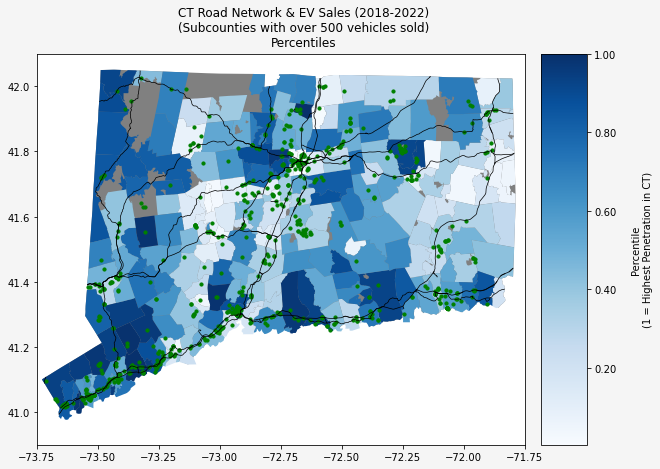

In [58]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,10), facecolor = 'whitesmoke')
ax.set_ylim(40.9, 42.1)
ax.set_xlim(-73.75, -71.75)

# Create divider
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "7%", pad = "-10%")
cax.yaxis.labelpad = 15

# Add plots
ct_bg = ct_boundaries.plot(ax=ax, 
                           facecolor = 'grey')

# Add zips and sales
ev_purchases_by_zip_geo_filtered.plot(ax=ax,
                    column = "Percentage_Percentile",
                    cmap = 'Blues',
                    cax = cax,
                    legend = True,
                    legend_kwds={"label": "Percentile\n(1 = Highest Penetration in CT)",
                                  "pad" : 0,
                                 'format':"%.2f"})

# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, 
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

# Plot state routes
# state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

# Plot local roads
# local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

# Plot interstates and US routes
interstates_plot = interstates.plot(ax=ax, color ='black', linewidth = 0.7, label = "Interstates")

# Add title
fig.suptitle("CT Road Network & EV Sales (2018-2022)\n(Subcounties with over 500 vehicles sold)\nPercentiles", y = 0.80)

plt.tight_layout()

plt.savefig(OUTPUT_FILEPATH / "ev_sales_18-22.png", dpi = 500)
plt.show()

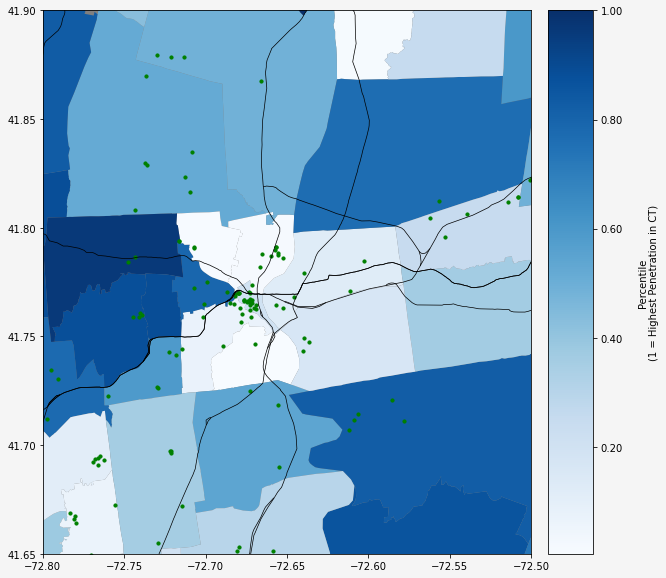

In [64]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,10), facecolor = 'whitesmoke')
ax.set_ylim(41.65, 41.9)
ax.set_xlim(-72.80, -72.5)

# Create divider
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "7%", pad = "-10%")
cax.yaxis.labelpad = 15

# Add plots
ct_bg = ct_boundaries.plot(ax=ax, 
                           facecolor = 'grey')

# Add zips and sales
ev_purchases_by_zip_geo_filtered.plot(ax=ax,
                    column = "Percentage_Percentile",
                    cmap = 'Blues',
                    cax = cax,
                    legend = True,
                    legend_kwds={"label": "Percentile\n(1 = Highest Penetration in CT)",
                                  "pad" : 0,
                                 'format':"%.2f"})

# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, 
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

# Plot state routes
# state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

# Plot local roads
# local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

# Plot interstates and US routes
interstates_plot = interstates.plot(ax=ax, color ='black', linewidth = 0.7, label = "Interstates")

# Add title
# fig.suptitle("CT Road Network & EV Sales (2018-2022)\n(Subcounties with over 500 vehicles sold)\nPercentiles", y = 0.80)

plt.tight_layout()

plt.savefig(OUTPUT_FILEPATH / "ev_sales_18-22.png", dpi = 500)
plt.show()

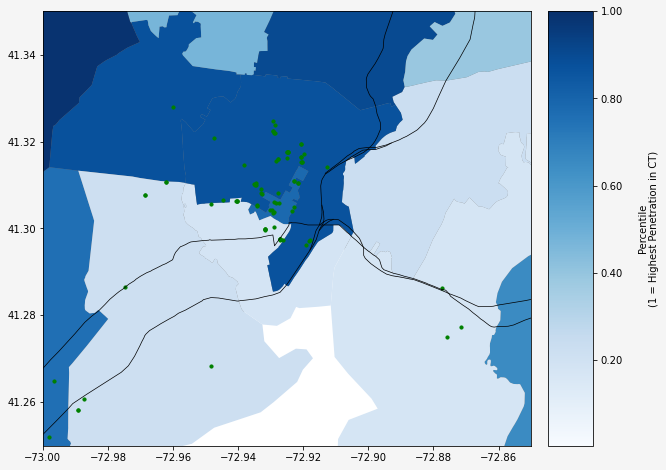

In [67]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (10,10), facecolor = 'whitesmoke')
ax.set_ylim(41.25, 41.35)
ax.set_xlim(-73, -72.85)

# Create divider
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "7%", pad = "-10%")
cax.yaxis.labelpad = 15

# Add plots
ct_bg = ct_boundaries.plot(ax=ax, 
                           facecolor = 'grey')

# Add zips and sales
ev_purchases_by_zip_geo_filtered.plot(ax=ax,
                    column = "Percentage_Percentile",
                    cmap = 'Blues',
                    cax = cax,
                    legend = True,
                    legend_kwds={"label": "Percentile\n(1 = Highest Penetration in CT)",
                                  "pad" : 0,
                                 'format':"%.2f"})

# Plot DCFC points
afdc_plot = charging_points.plot(ax=ax, 
                color = 'green', 
                markersize =10,
                label = "EV Charging Points")

# Plot state routes
# state_routes_plot = state_routes.plot(ax=ax, color = 'black', linewidth = 0.25, label = "State Routes")

# Plot local roads
# local_roads_plot = local_roads.plot(ax=ax, color = 'darkblue', linewidth = 0.1, label = "Local Roads")

# Plot interstates and US routes
interstates_plot = interstates.plot(ax=ax, color ='black', linewidth = 0.7, label = "Interstates")

# Add title
# fig.suptitle("CT Road Network & EV Sales (2018-2022)\n(Subcounties with over 500 vehicles sold)\nPercentiles", y = 0.80)

plt.tight_layout()

plt.savefig(OUTPUT_FILEPATH / "ev_sales_18-22.png", dpi = 500)
plt.show()

In [235]:
# Create Centroids
centroids = [ev_purchases_by_zip_geo["geometry"][i].centroid for i in range(len(ev_purchases_by_zip_geo))]
centroids = gpd.GeoDataFrame(centroids, geometry = centroids)
centroids["EVs_SOLD"] = ev_purchases_by_zip_geo["VEH_COUNT"]

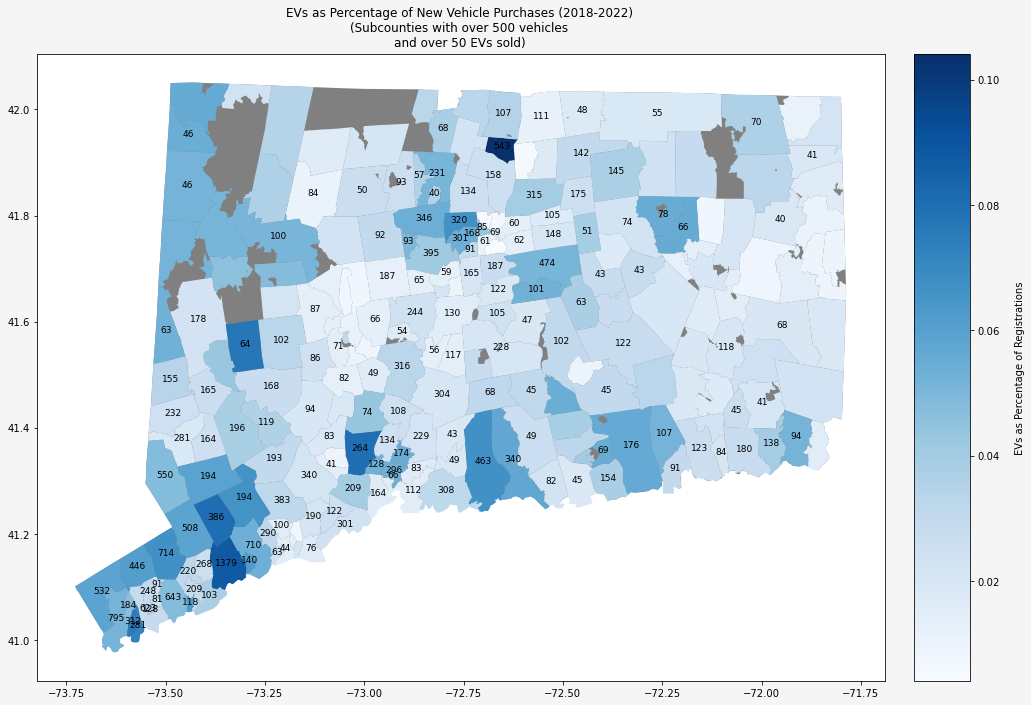

In [262]:
# Create figure
fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (16,16), facecolor = 'whitesmoke')

# Create divider
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = "-10%")
cax.yaxis.labelpad = 15

# Add plots
ct_bg = ct_boundaries.plot(ax=ax, 
                           facecolor = 'grey')

# Add zips and sales
ev_purchases_by_zip_geo_filtered.plot(ax=ax,
                    column = "Percentage",
                    cmap = 'Blues',
                    cax = cax,
                    legend = True,
                    legend_kwds={"label": "EVs as Percentage of Registrations",
                                  "pad" : 0,
                                 'format':"%.2f"})


for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, centroids["EVs_SOLD"]):
    if (label >= 40):
        label = f"{label:.0f}"
        ax.annotate(label, xy=(x, y),
                    xytext=(0, 0),
                    textcoords="offset points",
                    horizontalalignment = 'center',
                    size = 9)


# Add title
fig.suptitle("EVs as Percentage of New Vehicle Purchases (2018-2022)\n(Subcounties with over 500 vehicles\nand over 50 EVs sold)", y = 0.79)

# plt.legend()

plt.tight_layout()
plt.show()

### 2di. EV Sales x Income

In [6]:
ev_purchases_by_zip_geo["ZIP"] = ev_purchases_by_zip_geo["ZIP"].astype(int)
ev_purchases_by_zip_geo_income = ev_purchases_by_zip_geo.merge(zips_income, left_on = "ZIP", right_on = "ZIP")
ev_purchases_by_zip_geo_income["S1901_C01_012E"] = ev_purchases_by_zip_geo_income["S1901_C01_012E"].replace('-',0)
ev_purchases_by_zip_geo_income["S1901_C01_012E"] = ev_purchases_by_zip_geo_income["S1901_C01_012E"].astype(float)

In [8]:
# Restrict this to places with over 500 vehicles sold
ev_purchases_by_zip_geo_income =ev_purchases_by_zip_geo_income[ev_purchases_by_zip_geo_income["TOTAL_VEH_COUNT"]>500] 

In [10]:
ev_purchases_by_zip_geo_income

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,ZIP,ZIP_CODE,FuelTypePrimary,VEH_COUNT,Percentage,TOTAL_VEH_COUNT,geometry,Unnamed: 0,GEO_ID,NAME,S1901_C01_012E
0,06492,06492,B5,G6350,S,103033106,2188786,+41.4627247,-072.8050686,6492,6492,Electric,304.0,2.014846,15088.0,"POLYGON ((-72.88678 41.44647, -72.88677 41.446...",189.0,8600000US06492,ZCTA5 06492,79489.0
1,06751,06751,B5,G6350,S,49181767,740227,+41.6357587,-073.2114217,6751,6751,Electric,23.0,2.237354,1028.0,"POLYGON ((-73.26145 41.66464, -73.25791 41.664...",222.0,8600000US06751,ZCTA5 06751,92250.0
2,06424,06424,B5,G6350,S,101544342,4944738,+41.5601584,-072.5027646,6424,6424,Electric,102.0,3.076923,3315.0,"POLYGON ((-72.55445 41.51112, -72.55426 41.511...",155.0,8600000US06424,ZCTA5 06424,101629.0
3,06460,06460,B5,G6350,S,32195359,7384587,+41.2187991,-073.0456258,6460,6460,Electric,301.0,2.390976,12589.0,"POLYGON ((-73.12245 41.18290, -73.12195 41.185...",169.0,8600000US06460,ZCTA5 06460,86305.0
4,06405,06405,B5,G6350,S,55999083,19035590,+41.2799489,-072.7859502,6405,6405,Electric,308.0,3.172968,9707.0,"POLYGON ((-72.86424 41.26943, -72.86405 41.269...",141.0,8600000US06405,ZCTA5 06405,80073.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,06249,06249,B5,G6350,S,140113258,2986571,+41.6329550,-072.2400896,6249,6249,Electric,35.0,1.979638,1768.0,"POLYGON ((-72.33423 41.64360, -72.33218 41.644...",86.0,8600000US06249,ZCTA5 06249,95757.0
275,06375,06375,B5,G6350,S,20703171,2090414,+41.4063382,-072.1232358,6375,6375,Electric,21.0,2.282609,920.0,"POLYGON ((-72.17005 41.41047, -72.17001 41.410...",128.0,8600000US06375,ZCTA5 06375,96552.0
277,06247,06247,B5,G6350,S,86436684,1091791,+41.7678005,-072.0750258,6247,6247,Electric,12.0,2.051282,585.0,"POLYGON ((-72.12249 41.71275, -72.12171 41.715...",84.0,8600000US06247,ZCTA5 06247,75291.0
278,06281,06281,B5,G6350,S,139582211,2145245,+41.9734763,-072.0141365,6281,6281,Electric,70.0,3.676471,1904.0,"MULTIPOLYGON (((-72.07860 41.95849, -72.07841 ...",103.0,8600000US06281,ZCTA5 06281,89055.0


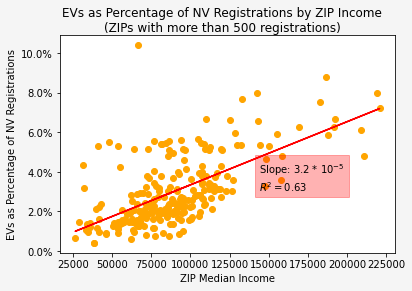

In [53]:
# Plot
fig, ax = plt.subplots(nrows=  1, ncols =1, facecolor = "whitesmoke")

# Create axes
evs = ax.scatter(
       x= ev_purchases_by_zip_geo_income[ev_purchases_by_zip_geo_income["S1901_C01_012E"]!=0]["S1901_C01_012E"],
       y=ev_purchases_by_zip_geo_income[ev_purchases_by_zip_geo_income["S1901_C01_012E"]!=0]["Percentage"],
       label = "L2 Chargers", color = 'orange')

pred = ax.plot(ev_purchases_by_zip_geo_income[ev_purchases_by_zip_geo_income["S1901_C01_012E"]!=0]["S1901_C01_012E"],
              predicted, marker = "None", linestyle = '-', color = 'red')

ann = ax.annotate('Slope: 3.2 * $10^{-5}$\n$R^2 = 0.63$',
            xy=(0.6, 0.45), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=10, color = 'black')

ann.set_bbox(dict(facecolor='red', alpha=0.3, edgecolor='red'))

ax.set_xlabel("ZIP Median Income")
ax.set_ylabel("EVs as Percentage of NV Registrations")
ax.yaxis.set_major_formatter(PercentFormatter())
plt.suptitle("EVs as Percentage of NV Registrations by ZIP Income\n(ZIPs with more than 500 registrations)")

plt.savefig(OUTPUT_FILEPATH/"evs_percentage_by_zip_income_plot.png", dpi=600)
plt.show()